# Regularization
### `! git clone https://github.com/ds4e/regularization`

## Downsides of Linear Models
- Last lecture, we looked at the horns of a dilemma of linear model-fitting:
  - Omitted Variables Bias: Leave out relevant variables, and the others will receive more weight in the regression to compensate, biasing the coefficient estimates and possibly the predictions
  - Multi-Colinearity/Bad Control: Put in too many correlated variables, and the model will deliver poor coefficient estimates and bad predictions
- This is a specific version of the *bias-variance trade-off*: Expected prediction error is the sum of the bias squared plus the predictor variance plus irreducible error
- This is very frustrating: You want a rich, interesting model, but striking a balance through trial-and-error is not science and often leads to selection bias and over-fitting
- **What is a modern, data driven way to resolve these issues, just like how ensembling can "fix" decision trees?**

## The Bias-Variance Tradeoff
- The basics of the bias-variance tradeoff is:
\begin{alignat*}{2}
\underbrace{\mathbb{E}_{D,\varepsilon}[(y-\hat{f}(x,D))^2]}_{\text{Expected prediction error}} &=&
\underbrace{(f(x)-\mathbb{E}_{D}[\hat{f}(x,D)])^2}_{\text{Bias squared}}\\
&+& \underbrace{\mathbb{E}_{D}[(\hat{f}(x,D)-\mathbb{E}_D[\hat{f}(x,D)])^2]}_{\text{Predictor Variance}}\\
&+&  \underbrace{\sigma^2}_{\text{Irreducible Error}}
\end{alignat*}
- Unbiased prediction is nice, but not sufficient or necessary for good prediction: Predictor variance also plays an important role
- Today's question: **How can we optimally constrain models to reduce their variance?**

# Constrained Optimization

## Unconstrained Optimization
- Often, we want to maximize or minimize (optimize) a function. Let's focus on minimization: We want to find the value $b$ that yields the lowest value of $f(b)$ possible.
- We typically have a function to be optimized,
$$
f(b) = \dfrac{1}{N} \sum_{i=1}^N (y_i - x_i \cdot b)^2
$$
- This problem is **unconstrained**: There are no further restrictions on $b$, and take any values we like
- We typically differentiate it and solve, or perhaps use gradient descent on a computer to determine the optimal $b^*$

## Constrained Optimization
- In many situations, however, the choice of $b$ is subject to **constraints**
- One example would **non-negativity constraints** that $b_k \ge 0$: Some of the coefficients must be weakly positive, for practical or theoretical reasons
- Another example is that the sum of the coefficients satisfy some budget, so that $b_1 + b_2 + ... + b_K \le w$
- There's a distinction between inequalities and equalities, but we don't have to worry about that for now
- These introduce a problem. Where do they go in our optimization framework? How do we optimize in the presence of these kinds of details?

## Our Favorite Constraints
- To avoid getting too general, there are two constraints we are interested in:
    1. The $L_1$ penalty: $|b_1| + |b_2| + ... + |b_K| \le w$, so the sum of the absolute values of the coefficients are all less than some value $w$
    2. The $L_2$ penalty: $b_1^2 + b_2^2 + ... + b_K^2 \le w$, so the sum of squares of the coefficients are all less than some value $w$
- We are going to impose constraints like these directly on the estimation of our models in order to reduce their variance
- This is clever: **Shrink the coefficients** and you can keep the model from over-fitting
- Minimizing SSE subject to the $L_1$ penalty leads to a tool called the LASSO, and subject to the $L_2$ penalty leads to ridge regression

## The Penalty Approach
- The way to incorporate constraints is outrageously clever, and due to a very dead Frenchman named Lagrange
- The trick is to treat a violation of a constraint as additional cost, and add it to the function to be minimized: This is called the method of **Lagrange multipliers**
- To keep things clear, let's adopt the $L_1$ constraint, that $\sum_{k=1}^L |b_k| \le w$
- Intuitively, the penalty approach is: "The value of $\sum_{k=1}^L |b_k| $ must not exceed $w$, or you've made a mistake and must be penalized for cheating. So if you the constraint and $\sum_{k=1}^L |b_k|  - w \ge 0$", we're going to impose an additional cost on you."
- So the amount by which the constraint is violated is
$$
|b_1| + |b_2| + ... + |b_K| - w
$$
- If this were positive, we would be choosing a coefficient vector that is larger than prescribed

## The Penalty Approach
- So if we want to minimize $f(b)$ subject to the $L_1$ constraint that, say, $|b_1| + |b_2| + ... + |b_K| \le w$, we create a function called a Lagrangian:
$$
\mathcal{L}(b, \lambda) = f(b) + \lambda \underbrace{(|b_1| + |b_2| + ... + |b_K| - w)}_{\text{Constraint violation}}
$$
and $\lambda$ is called a **Lagrange multiplier** (in code it will be called `alpha` by Sci-Kit and `lambda` by glmnet)
- So if we are violating the constraint and $|b_1| + |b_2| + ... + |b_K| > w$, it is counted as extra cost against our objective $f(b)$
- Here's the key idea:
    - If the constraint is not violated, decrease $\lambda$, and the model will naturally become more complex
    - If the constraint is violated, increase $\lambda$, and the model will become simpler
    - If the constraint is exactly satisfied, you've (probably) found a solution to the original problem
- This is extremely clever, and has very deep math behind it

## The Penalty Approach
- In practice, ML/DS people don't typically worry about the constraint per se: They focus on solving the unconstrained problem
$$
\mathcal{L}(b, \lambda) = f(b) + \lambda (|b_1| + |b_2| + ... + |b_K|)
$$
taking $\lambda$ as given and not worrying about the constraint, and then tweak $\lambda$ as necessary
- So we have taken our constrained problem and turned it into an unconstrained one, by way of the Lagrange multiplier
- We've worried about solving unconstrained problems a lot: We typically take a derivative, set it equal to zero, and solve if we're using paper and pencil; or use gradient descent on the computer

## Penalty-Multiplier Connection
- I think this is really helpful to understand what regularization is doing
- But to be honest, we typically don't worry about the $w$ and just tune the $\lambda$, picking it by cross validation
- This is because we don't have "real" constraints, and it's easier to worry about selecting $\lambda$ by cross validation, rather than using cross validation to pick $w$ (and then solve for $\lambda$ anyway)
- This can be a little confusing, since a lot of our intuition will come from constrained optimization and software will refer directly to $\lambda$ but not $w$

# Regularization

## Controlling Model Variance
- What is the simplest, most brute-force way to reduce the variance of a linear model?
- Well, reduce the size of each coefficient $b_{\ell}$: If each $x_{i\ell}$ has a smaller impact on $y_i$ through $b_\ell$, then the model will be lower variance
- This introduces a bias: The model will no longer converge to the "truth" as the sample size gets large by way of the WLLN. But we're focused on the Bias-Variance Trade-off: We are willing to tolerate bias as long as our models improve in predictive performance.
- The nicest part is that $L_1$ penalized regression (the LASSO) will automatically select variables for you
- $L_2$ penalized regression (ridge regression) is more popular with neural networks, because the constraint is easier to deal with

## Regularized Regression and Shrinkage
- So we give the linear regression a "budget constraint": The sum of the magnitudes of the coefficients cannot be greater than the constraint, $w$:
$$
|b_{1}|+|b_2|+...+|b_K| \le w,
$$
and our Lagrangian is then
$$
\frac{1}{N} \sum_{i=1}^N (y_i - x_i b)^2 + \lambda\left( |b_1| + |b_2| + ... + |b_L| \right)
$$
for the LASSO
- If, instead, we use the constraint,
$$b_{1}^2+ b_2^2+...+b_K^2 \le w
$$
then our Lagrangian is
$$
\frac{1}{N} \sum_{i=1}^N (y_i - x_i b)^2 + \lambda\left( b_{1}^2+ b_2^2+...+b_K^2 \right)
$$

## Regularized Regression and Shrinkage
- Where does this idea come from?
- This idea simultaneously comes from different traditions:
  - What happens when you have more variables than data points? (Regularization: ill-posed problems, big data)
  - What happens when your model exhibits high variability or you have lots of data but are unsure how to engineer an effective feature space? (Shrinkage: optimal prediction, bias-variance trade-off)
- The constraint forces the algorithm to make choices when there are "too many variables": Which variables reduce `SSE` the most? Which are the most correlated, and therefore least useful to add together?

## OLS Minimization
- OLS minimizes the `SSE`:

<div>
<img src="https://github.com/ds4e/regularization/blob/main/src/ols_minimization.png?raw=1" width="500"/>
</div>

## The LASSO Constraint
- The new $b$ must be chosen inside the box:
  
<div>
<img src="https://github.com/ds4e/regularization/blob/main/src/lasso_constraint.png?raw=1" width="500"/>
</div>


## The LASSO Regression
- The best $b$ inside the box is selected:

<div>
<img src="https://github.com/ds4e/regularization/blob/main/src/lasso_regression.png?raw=1" width="500"/>
</div>


## Why LASSO is Special
- Because of the form of the constraint, $\sum_{k=1}^K |b_k| \le c$, the LASSO will "zero out" a bunch of variables
- Even though, in principle, it could pick $|b_k|>0$ for many of the variables, it rarely does
- When LASSO zeroes out a variable, we can imagine that it "wasn't picked"
- Mathematically, this is because $|x|$ has a "kink" at zero, where the slope goes from -1 to 1, so the "budget set" for the LASSO has "corners." Because of this, the LASSO is very aggressive about throwing out variables, rather than a constraint like $x^2$ which would merely reduce the size of coefficients

## Picking $\lambda$
- How does the price of failure $\lambda$ actually get selected?
- We use cross validation: There's a grid of $\lambda$ values that corresponds to the model space. The code splits the data into $K$ folds, solves the Lagrangian taking each $\lambda$ as given, and returns the $RMSE$ or $R^2$ or Accuracy, as is appropriate

# LASSO in Sci-Kit

- Scikit has a Lasso module, but the inventors of the Lasso have a package called `glmnet` that is extremely well done
- Out of the box, `sklearn` performs the Lasso, but `glmnet` can be used to do a bunch of other things (including a LASSO logit/probit, survival analysis, and multinomial response models)
- The Lasso is in the `linear_model` module
    - `from sklearn import linear_model` imports the linear models module
    - `lasso = linear_model.Lasso(alpha=1.0)` creates a Lasso regression
    - `lasso.fit(X,y)` runs the regression
    - `lasso.coef_` returns the regression coefficients.

# Examples

## Example: Housing Price Regression
- 16,814 observations of 19 variables for house sales in Pierce County, NC
- Want to predict house price from characteristics ("hedonic pricing")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Wrangle:
df = pd.read_csv('./data/pierce_county_house_sales.csv')
df = df.drop(['sale_date'],axis=1)
df = df.drop(['view_quality'],axis=1)

df['waterfront_type'] = df['waterfront_type'].fillna('none')
df['age'] = max(df['year_built'])-df['year_built']
df = df.drop(['year_built'],axis=1)
df['price_log'] = np.log(df['sale_price'])

df['intercept']=np.ones(df.shape[0])

#print(df.isna().sum())
df = df.dropna()
print(df.isna().sum())

df.head()

def maxmin(z):
    z = (z-np.min(z))/(np.max(z)-np.min(z))
    return z


sale_price                     0
house_square_feet              0
attic_finished_square_feet     0
basement_square_feet           0
attached_garage_square_feet    0
detached_garage_square_feet    0
fireplaces                     0
hvac_description               0
exterior                       0
interior                       0
stories                        0
roof_cover                     0
bedrooms                       0
bathrooms                      0
waterfront_type                0
utility_sewer                  0
age                            0
price_log                      0
intercept                      0
dtype: int64


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(1, 0, 'sale_price'),
  Text(2, 0, 'house_square_feet'),
  Text(3, 0, 'attic_finished_square_feet'),
  Text(4, 0, 'basement_square_feet'),
  Text(5, 0, 'attached_garage_square_feet'),
  Text(6, 0, 'detached_garage_square_feet'),
  Text(7, 0, 'fireplaces'),
  Text(8, 0, 'stories'),
  Text(9, 0, 'bedrooms'),
  Text(10, 0, 'bathrooms'),
  Text(11, 0, 'age'),
  Text(12, 0, 'price_log'),
  Text(13, 0, 'intercept')])

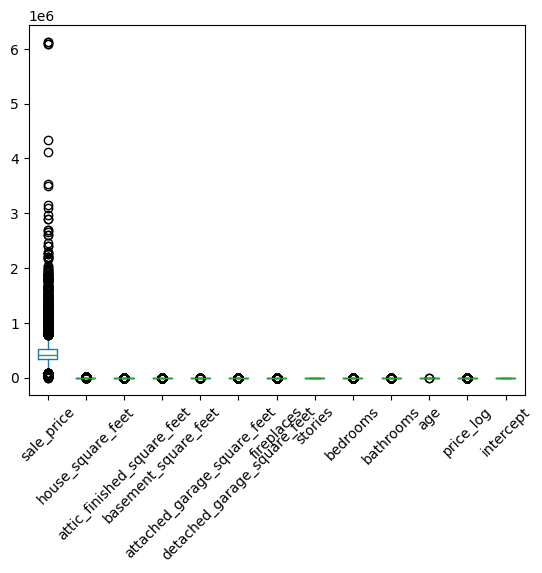

In [ ]:
df.plot.box()
plt.xticks(rotation=45)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

# Target variable:
#y = df['price_log']
y = df['sale_price']

# Numeric:
var_num = ['house_square_feet', 'attic_finished_square_feet',
       'basement_square_feet', 'attached_garage_square_feet',
       'detached_garage_square_feet',
       'age',
      'bedrooms', 'bathrooms','stories']
X_num = df.loc[:,var_num]

expander = PolynomialFeatures(degree=5,include_bias=False, interaction_only=True) # Create the expander
Z = expander.fit_transform(X_num) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
zdf = zdf.apply(maxmin)

# Dummies:
var_cat = [ 'hvac_description',
       'exterior', 'interior', 'roof_cover',
        'waterfront_type', 'utility_sewer','roof_cover']
dummies = pd.DataFrame()
for var in var_cat:
    new_dummies = pd.get_dummies( df.loc[:,var].copy(), dtype=int)
    dummies = pd.concat([dummies, new_dummies], axis=1, ignore_index=True)

# Create covariates:
zdf = zdf.reset_index()
dummies = dummies.reset_index()

X = pd.concat([zdf, dummies], axis=1, ignore_index=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=100)

- Let's look at how OLS does with this big feature space

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm= lm.fit(X_train,y_train)
print('R^2, OLS, train: ', lm.score(X_train,y_train))
print('R^2, OLS, test: ', lm.score(X_test,y_test))

R^2, OLS, train:  0.6354011057646707
R^2, OLS, test:  -0.9207329496286307


<Axes: ylabel='Proportion'>

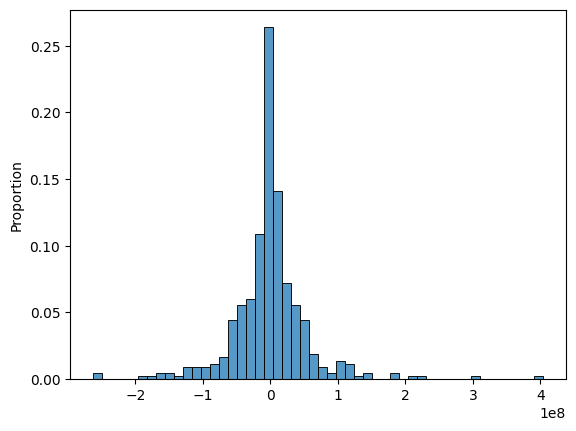

In [ ]:
import seaborn as sns
sns.histplot(lm.coef_, bins = 50, stat='proportion')

In [ ]:
from sklearn.linear_model import Lasso

# Run LASSO:
reg = Lasso(alpha=2.5,
            warm_start=True,
            max_iter=2500)
reg.fit(X_train,y_train)

print('R^2, Lasso, train: ', reg.score(X_train,y_train))
print('R^2, Lasso, test: ', reg.score(X_test,y_test))

sdf = pd.DataFrame({'variable': X.columns, 'slope':reg.coef_})

R^2, Lasso, train:  0.5983084262431206
R^2, Lasso, test:  0.5954569706647248


/home/trj2j/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.611e+14, tolerance: 7.766e+10
  model = cd_fast.enet_coordinate_descent(


- Can we see the shrinkage happen?

Computing regularization path using the lasso...


/home/trj2j/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 520047160076.0, tolerance: 364708348177.99274
  model = cd_fast.enet_coordinate_descent_gram(
/home/trj2j/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 799684278138.5, tolerance: 364708348177.99274
  model = cd_fast.enet_coordinate_descent_gram(
/home/trj2j/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1223822944271.25, tolerance: 364708348177.99274
  model = cd_fast.enet_coordinate_descent_gram(
/home/trj2j/miniconda3/lib/python3.12/site-packages/sklearn/linear_mode

(np.float64(0.6849910345552279),
 np.float64(11663204285.713594),
 np.float64(-9263867.528227149),
 np.float64(11566640.396826737))

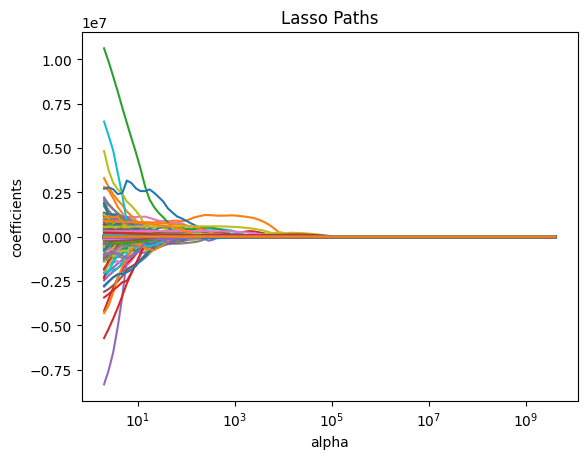

In [ ]:
from sklearn.linear_model import lasso_path

eps = 5e-10

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, eps=eps)

for coef_lasso in coefs_lasso:
    l1 = plt.semilogx(alphas_lasso, coef_lasso)

plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Lasso Paths")
plt.axis("tight")

- How does it achieve this improvement in performance over OLS with the big feature space?
- It sets most of the coefficients to zero

<Axes: xlabel='slope', ylabel='Proportion'>

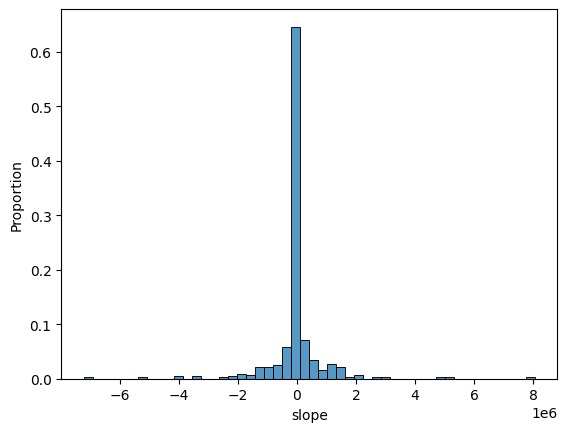

In [ ]:
import seaborn as sns
sns.histplot(sdf['slope'], bins = 50, stat='proportion')

## Example: Heart Failure
- Let's revisit the CariacPatientsData

In [ ]:
df = pd.read_csv('./data/CardiacPatientData.csv')
print( df.shape )
df.head()

(5906, 20)


,ID,SBP,DBP,HR,RR,BT,SpO2,Age,Gender,GCS,Na,K,Cl,Urea,Ceratinine,Alcoholic,Smoke,FHCD,TriageScore,Outcome
0,1,163,95,90,18,98,98,66,1,15,139.0,4.0,105.0,41.0,91.0,1.0,1.0,0.0,3.0,1
1,1,134,85,85,15,98,98,66,1,15,139.0,4.0,105.0,41.0,91.0,1.0,1.0,0.0,3.0,1
2,1,121,77,80,19,98,98,66,1,15,139.0,4.0,105.0,41.0,91.0,1.0,1.0,0.0,3.0,1
3,1,103,78,70,16,98,98,66,1,15,139.0,4.0,105.0,41.0,91.0,1.0,1.0,0.0,3.0,1
4,1,96,70,59,13,98,98,66,1,15,139.0,4.0,105.0,41.0,91.0,1.0,1.0,0.0,3.0,1


In [ ]:
df = df.drop('ID',axis=1)
np.sum( df.isna(), axis=0)

SBP               0
DBP               0
HR                0
RR                0
BT                0
SpO2              0
Age               0
Gender            0
GCS               0
Na             3244
K              3244
Cl             3248
Urea           3320
Ceratinine     3261
Alcoholic      1751
Smoke          1752
FHCD           1621
TriageScore    1903
Outcome           0
dtype: int64

In [ ]:
has_missing = ['Na', 'K', 'Cl', 'Urea', 'Ceratinine', 'Alcoholic', 'Smoke', 'FHCD',
        'TriageScore']

# for var in has_missing:
#     df[var+'_NA'] = df[var].isna() # Missing dummy
#     df[var] = df[var].fillna(0) # Replace missings with zero

df = df.drop(has_missing, axis=1)


In [ ]:
np.sum( df.isna(), axis=0)

SBP        0
DBP        0
HR         0
RR         0
BT         0
SpO2       0
Age        0
Gender     0
GCS        0
Outcome    0
dtype: int64

In [ ]:
# Numeric:
y = df['Outcome']
X = df.drop('Outcome',axis=1)

expander = PolynomialFeatures(degree=4,include_bias=False, interaction_only=False) # Create the expander
Z = expander.fit_transform(X) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
Z = zdf.apply(maxmin)

X_train, X_test, y_train, y_test = train_test_split(Z, y,
                                                    test_size=0.2,
                                                    random_state=100)

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm= lm.fit(X_train,y_train)
print('R^2, OLS, train: ', lm.score(X_train,y_train))
print('R^2, OLS, test: ', lm.score(X_test,y_test))

R^2, OLS, train:  0.7296208807974429
R^2, OLS, test:  -2720575761425927.5


<Axes: ylabel='Proportion'>

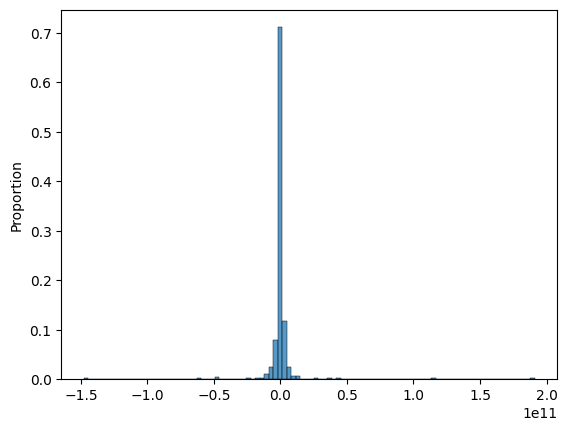

In [ ]:
sns.histplot(lm.coef_, bins = 100, stat='proportion')

In [ ]:
# Run LASSO:
reg = Lasso(alpha=0.0005,
            warm_start=True,
            max_iter=2500)
reg.fit(X_train,y_train)

print('R^2, Lasso, train: ', reg.score(X_train,y_train))
print('R^2, Lasso, test: ', reg.score(X_test,y_test))

sdf = pd.DataFrame({'variable': X_test.columns, 'slope':reg.coef_})

R^2, Lasso, train:  0.3918635718808716
R^2, Lasso, test:  0.38289725926357177


Computing regularization path using the lasso...


/home/trj2j/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45319224765853505, tolerance: 0.4036
  model = cd_fast.enet_coordinate_descent_gram(
/home/trj2j/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4745362034096843, tolerance: 0.4036
  model = cd_fast.enet_coordinate_descent_gram(
/home/trj2j/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5274319965180894, tolerance: 0.4036
  model = cd_fast.enet_coordinate_descent_gram(
/home/trj2j/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:

(np.float64(1.4302119572383371e-10),
 np.float64(2.4351930737271683),
 np.float64(-66.34619732644678),
 np.float64(112.11930809724586))

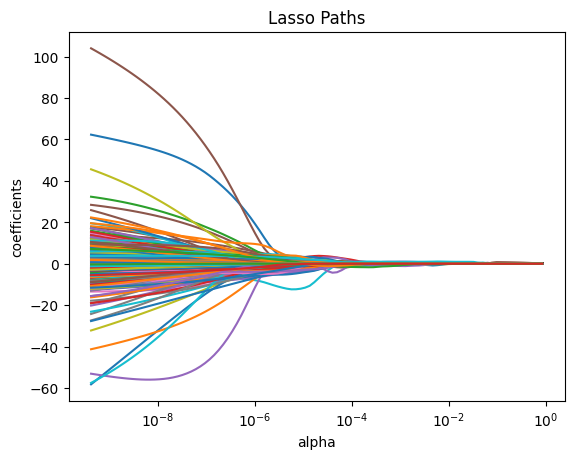

In [ ]:
from sklearn.linear_model import lasso_path

eps = 5e-10

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, eps=eps)

for coef_lasso in coefs_lasso:
    l1 = plt.semilogx(alphas_lasso, coef_lasso)

plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Lasso Paths")
plt.axis("tight")

<Axes: xlabel='slope', ylabel='Proportion'>

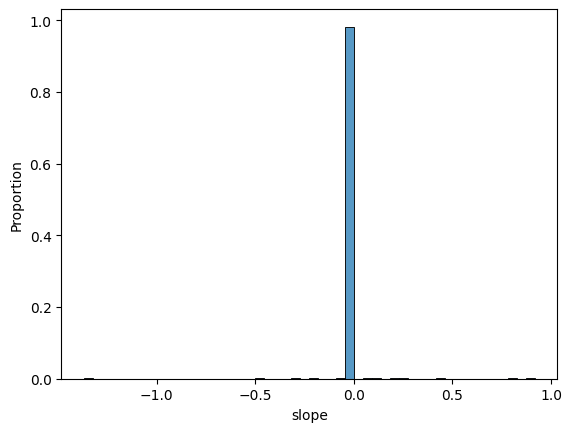

In [ ]:
import seaborn as sns
sns.histplot(sdf['slope'], bins = 50, stat='proportion')

- Only a handful of coefficients are actually non-zero

# Conclusion


## Conclusion
- So now you have the full machine learning toolbox:
  - $k$-NN: Highly non-parametric, local prediction
  - $k$-MC: Unsupervised learning algorithm for searching data for patterns
  - Linear Models, Logistic Regression: Optimally weight the explanatory variables
  - Trees: Highly non-linear but fragile; highly interpretable
  - Principal Components Analysis: Orthogonalize your variables and use a subset; unsupervised learning for numeric variables
  - Neural Networks: Layered, highly parameterized versions of our previous models
  - Random Forests: Use ensemble learning and data-hiding to improve decision tree performance
  - LASSO, ridge regression: Data-driven variable selection for linear models
- Random Forests, Neural Nets, and LASSO are very powerful: People really use these for serious work as benchmark tools for machine learning